# Pendahuluan

* coming soon

# Import library

In [ ]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-6-593e4c34e335>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Get Data

In [ ]:
# buat function 
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e



In [ ]:
# # Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'

# Choose a date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')

stock['Symbol'] = symbol_to_fetch
stock.tail()

#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch
# show dataset
stock['Close'].tail()

DateTime
2022-12-26 02:00:00    4639.029785
2022-12-27 02:00:00    4582.570801
2022-12-28 02:00:00    4535.521484
2022-12-29 02:00:00    4582.570801
2022-12-30 02:00:00    4648.439453
Name: Close, dtype: float64

In [ ]:
# Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'
# Choose a date range
start_date = str(datetime(2012, 1, 1).date())
end_date = str(datetime(2021, 12, 31).date())
# end_date = datetime.now().strftime('%Y-%m-%d')

# Preprocessing

In [ ]:
# check missing value
stock.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Symbol    0
dtype: int64

In [ ]:
# Load stock price data from a CSV file
stock_price_data = stock.copy()

# Rename columns to the format expected by Prophet
stock_price_data = stock_price_data.rename(columns={'Date': 'ds', 'Close': 'y'})



In [ ]:
stock_price_data = stock_price_data.drop(['Open','High','Low','Volume','Symbol'],axis=1)

In [ ]:
stock_price_data = stock_price_data.reset_index().rename(columns={stock_price_data.index.name:'ds'})

In [ ]:
stock_price_data

,ds,y
0,2012-01-02 02:00:00,953.869324
1,2012-01-03 02:00:00,967.896912
2,2012-01-04 02:00:00,974.910706
3,2012-01-05 02:00:00,974.910706
4,2012-01-06 02:00:00,967.896912
...,...,...
2728,2022-12-26 02:00:00,4639.029785
2729,2022-12-27 02:00:00,4582.570801
2730,2022-12-28 02:00:00,4535.521484
2731,2022-12-29 02:00:00,4582.570801


# Modelling

In [ ]:
# Create and fit Prophet model to training data
prophet_model = Prophet()
# Split data into train and test sets (90;10)
train_data, test_data = train_test_split(stock_price_data, test_size=0.1, shuffle=False)

In [ ]:
prophet_model = Prophet()
prophet_model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb3a0d2ap/_4k7bch6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb3a0d2ap/go8dxott.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78787', 'data', 'file=/tmp/tmpb3a0d2ap/_4k7bch6.json', 'init=/tmp/tmpb3a0d2ap/go8dxott.json', 'output', 'file=/tmp/tmpb3a0d2ap/prophet_modelyut4vazn/prophet_model-20230520063542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:35:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:35:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Evaluasi

Prophet
Training data length: 2459
Test data length: 274
MAPE of the forecast: 0.10%


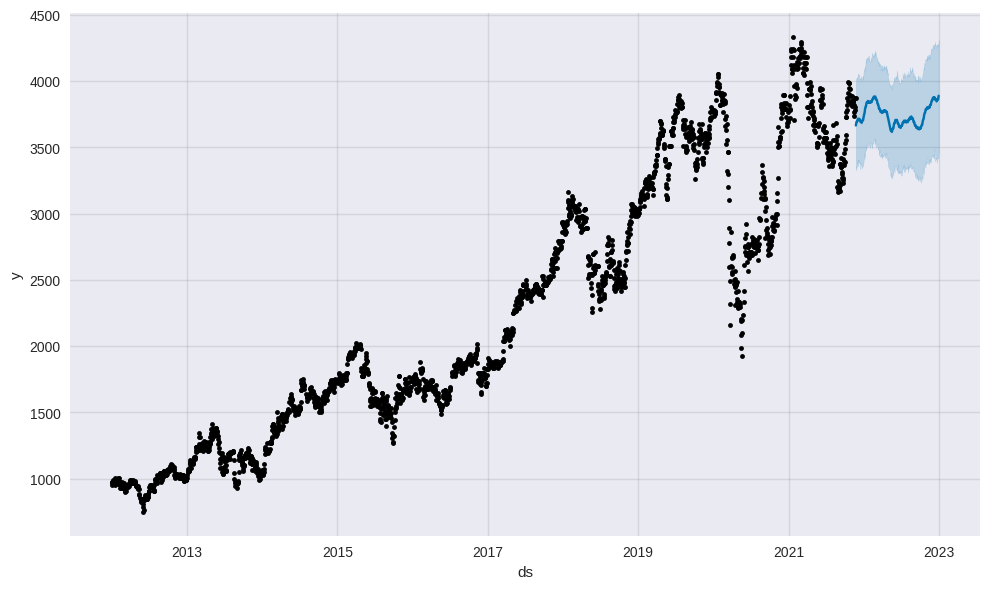

In [ ]:
# Make predictions on test data using Prophet model
forecast = prophet_model.predict(test_data[['ds']])

# Compute MAPE of the forecast
mape = mean_absolute_percentage_error(test_data['y'], forecast['yhat'])

# Print summary of results
print(f'Prophet')
print(f'Training data length: {len(train_data)}')
print(f'Test data length: {len(test_data)}')
print(f'MAPE of the forecast: {mape:.2f}%')

# Plot the Prophet forecast
fig = prophet_model.plot(forecast)
plt.show()